In [35]:
csv_path = '../../database/dayli_collections/dayli_col.csv'

In [1]:
import pandas as pd
import pickle
from db import DBHandler
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%%time

dtypes = {
    'user.id_str': str,
    'id_str': str,
    'text': str,
    'retweeted_status.id_str': str ,
    'retweeted_status.user.id_str': str,
    'retweet_count': int,
    'quoted_status_id_str': str,
}
df = pd.read_csv(csv_path, dtype=dtypes)

# parse dates
datetime_cols = [c for c in df.columns if 'created_at' in c]
for c in datetime_cols:
    df[c] = pd.to_datetime(df[c])

# reemplazar nombre de columnas: . por __ para sintactic sugar de pandas.
df.rename(columns=lambda x: x.replace('.', '__'), inplace=True)

CPU times: user 2min 21s, sys: 499 ms, total: 2min 22s
Wall time: 2min 22s


In [3]:
df.tail()

,created_at,user__id_str,id_str,text,retweeted_status__id_str,retweeted_status__user__id_str,retweeted_status__created_at,retweet_count,quoted_status_id_str
378490,2018-11-04 01:00:00,118732136,1058886546021994496,Horror en San Marcos Sierras\nEl Show de la Ma...,NaN,NaN,NaT,0,NaN
378491,2018-11-04 00:00:00,118732136,1058871446255079424,Preocupan los casos de violencia intrafamiliar...,NaN,NaN,NaT,0,NaN
378492,2018-11-04 23:52:00,309812848,1059231820942794752,#LaCornisa Tras más de una década de apología ...,NaN,NaN,NaT,4,NaN
378493,2018-11-04 23:31:00,309812848,1059226536136658950,"Seguimos con un país en #LaCornisa, pero sólo ...",NaN,NaN,NaT,8,NaN
378494,2018-11-04 14:52:33,84644827,1059096066493239296,RT @Guillevelez1: Entre el nuevo álbum de Juan...,1055847600337887233,909103393,2018-10-26 15:44:19,2,NaN


In [4]:
### READ FROM MONGODB CONNECTION


# h = DBHandler(port=27017)

# columns = ['created_at', 'id_str', 'retweet_count', 'retweeted_status__id_str', 'retweeted_status__created_at']
# separator = '__'
# project = ({f_name: '$' + f_name.replace(separator, '.') for f_name in columns})
# project.update({'retweeted_status': '$retweeted_status.id_str'})


# cursor = h.tweet_collection.aggregate([
#     {'$project': project}
# ])
# df = pd.DataFrame(list(cursor))

# # datatype conversion
# datetime_cols = [c for c in df.columns if 'created_at' in c]
# for c in datetime_cols:
#     df[c] = pd.to_datetime(df[c])

In [5]:
# usefull aliases
def df_only_rt(data_f):
    return data_f[data_f.retweeted_status__id_str.notna()]

def df_not_rt(data_f):
    return data_f[data_f.retweeted_status__id_str.isna()]

def df_commented(data_f):
    return data_f[data_f.quoted_status_id_str.notna()]

### Basic counts

In [6]:
%%time
quantity_of_users_on_ds = df.user__id_str.value_counts().count()
quantity_of_tweets_on_ds = df.id_str.value_counts().count()
print('Hay {} usuarios en el dataset.'.format(quantity_of_users_on_ds))
print('Hay {} tweets en el dataset.'.format(quantity_of_tweets_on_ds))
print(df.describe())

Hay 4171 usuarios en el dataset.
Hay 378488 tweets en el dataset.
       retweet_count
count  378495.000000
mean      230.279607
std      3104.433470
min         0.000000
25%         0.000000
50%         2.000000
75%        17.000000
max    385289.000000
CPU times: user 730 ms, sys: 0 ns, total: 730 ms
Wall time: 783 ms


# Recorte 1: tomar solo retweets que relacionan nuestros usuarios

Para algunos puntos desarrollados se tendrá en cuenta un recorte de dataset: Éste consiste en tomar, de todos los tweets recogidos, sólo aquellos que relacionan nuestros usuarios considerados para el estudio.

Se usará 'Global' para referirse a la totalidad de los tweets, y 'Recorte 1' para referirse a la selección mencionada.

(Problema 1: el campo retweeted_status devuelve el tweet original, no el tweet que se retweeteo. Es decir que si se trata de un RT de un RT, la relación retweeted_status ignora los intermedios y señala el tweet original.)

In [7]:
%%time
# df.id_str tiene tweets originales de nuestros usuarios, por haber levantado timelines.

# estas tres cuentas dan cosas raras!!! (mirar la cantidad tmb, parecida a la cantidad de tweets-no-rt)
a = df.retweeted_status__id_str.isin(df.id_str).sum(), \
df.retweeted_status__id_str.isin(df_not_rt(df).id_str).sum(), \
df.retweeted_status__user__id_str.isin(df.user__id_str).sum()
print(a)

# df[~ df.retweeted_status__id_str.isin(df_not_rt().id_str) & \
#    df.retweeted_status__user__id_str.isin(df.user__id_str)]

(25455, 25455, 26851)
CPU times: user 530 ms, sys: 4.01 ms, total: 534 ms
Wall time: 550 ms


In [8]:
df[df.user__id_str == str(69416519)]

,created_at,user__id_str,id_str,text,retweeted_status__id_str,retweeted_status__user__id_str,retweeted_status__created_at,retweet_count,quoted_status_id_str
21911,2018-10-28 23:57:00,69416519,1056696363952431105,Guillermo analiza cambiar un delantero y el es...,NaN,NaN,NaT,0,NaN
21912,2018-10-28 23:55:00,69416519,1056695861164556289,"La historia de ""El Paisa"": de custodio de un r...",NaN,NaN,NaT,3,NaN
21913,2018-10-28 23:53:36,69416519,1056695510004916225,IBM compró la desarrolladora de software de có...,NaN,NaN,NaT,9,NaN
21914,2018-10-28 23:50:00,69416519,1056694604337078272,Martín Lousteau inauguró una muestra sobre Raú...,NaN,NaN,NaT,2,NaN
21915,2018-10-28 23:45:00,69416519,1056693344221323264,La Villa Olímpica después de los Juegos: la il...,NaN,NaN,NaT,11,NaN
21916,2018-10-28 23:43:02,69416519,1056692851541766144,Jair Bolsonaro se impuso en segunda vuelta y e...,NaN,NaN,NaT,23,NaN
21917,2018-10-28 23:40:00,69416519,1056692086357946368,"La nueva vida del Pastor Giménez, de líder esp...",NaN,NaN,NaT,1,NaN
21918,2018-10-28 23:35:00,69416519,1056690827685031936,"Con un triplete de Luis Suárez, el Barcelona h...",NaN,NaN,NaT,5,NaN
21919,2018-10-28 23:30:00,69416519,1056689569175748608,La vida austera y el triste final de Ramón Val...,NaN,NaN,NaT,16,NaN
21920,2018-10-28 23:27:00,69416519,1056688814712852481,Qué se sabe y qué no de la tragedia que acabó ...,NaN,NaN,NaT,6,NaN


In [9]:
### PROTOTYPE-FILTERING
def df_cut1(data_f):
    # tweets originales, o RT que su tweet original está en el dataset.
    return data_f[data_f.retweeted_status__id_str.isin(df.id_str) | data_f.retweeted_status__id_str.isna()] # df.id_str -> porque quiero todos mis usuarios!

### 1 Proporciones de RT sobre tweets totales

In [10]:
def print_dataset_proportions(data_f):
    cant_rt = df_only_rt(data_f).shape[0]
    cant_orig = df_not_rt(data_f).shape[0]
    cant_resp = df_commented(data_f).shape[0]
    total = data_f.shape[0]
    print('Cantidad de tweets originales: \t\t{}'.format(cant_orig))
    print('Cantidad de RT en el Dataset: \t\t{}'.format(cant_rt))
    print('Cantidad de respuestas a tweets: \t{}'.format(cant_resp))
    print('Total: \t\t\t\t\t{}\n'.format(total))
    cants = pd.DataFrame({'cantidades': [cant_orig, cant_rt , cant_resp]},
                         index=['originales', 'retweets', 'respuestas'])
    ax = (cants/1000).plot.bar(y='cantidades', figsize=(5, 5), legend=[])
    ax.set_title('Cantidades de tweets (miles)')

    print('Proporcion de RT sobre total: \t\t\t{}'.format(cant_rt / total))
    print('Proporcion de Tweets originales sobre total: \t{}'.format(cant_orig / total))
    print('Proporcion de Tweets originales sobre total: \t{}\n'.format(cant_resp / total))

    commented_and_retweeted = data_f[(data_f.quoted_status_id_str.notna()) & \
                                     (data_f.retweeted_status__id_str.notna())]\
                                    .shape[0]
    commented_and_not_rt = data_f[(data_f.quoted_status_id_str.notna()) & \
                                  (data_f.retweeted_status__id_str.isna())] \
                                 .shape[0]
    print('Cantidad tweets comentados y retweeteados: \t{}'.format(commented_and_retweeted))
    print('Cantidad tweets comentados y NO retweeteados: \t{}'.format(commented_and_not_rt))
    print('Intersecciones no vacías?????????? TODO: hacer pruebas de cuál es la diferencia!')

### 1.0 Proporciones de RT sobre tweets totales (Global)

Cantidad de tweets originales: 		267784
Cantidad de RT en el Dataset: 		110711
Cantidad de respuestas a tweets: 	30065
Total: 					378495

Proporcion de RT sobre total: 			0.2925032034769284
Proporcion de Tweets originales sobre total: 	0.7074967965230716
Proporcion de Tweets originales sobre total: 	0.07943301760921545

Cantidad tweets comentados y retweeteados: 	10972
Cantidad tweets comentados y NO retweeteados: 	19093
Intersecciones no vacías?????????? TODO: hacer pruebas de cuál es la diferencia!
CPU times: user 486 ms, sys: 3.95 ms, total: 490 ms
Wall time: 571 ms


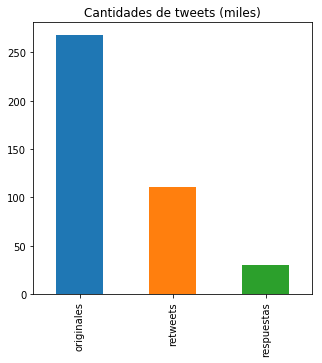

In [11]:
%%time
print_dataset_proportions(df)

### 1.1 Proporciones de RT sobre tweets totales (Recorte 1)

Cantidad de tweets originales: 		267784
Cantidad de RT en el Dataset: 		25455
Cantidad de respuestas a tweets: 	22164
Total: 					293239

Proporcion de RT sobre total: 			0.08680632521595012
Proporcion de Tweets originales sobre total: 	0.9131936747840499
Proporcion de Tweets originales sobre total: 	0.07558339784271532

Cantidad tweets comentados y retweeteados: 	3071
Cantidad tweets comentados y NO retweeteados: 	19093
Intersecciones no vacías?????????? TODO: hacer pruebas de cuál es la diferencia!
CPU times: user 786 ms, sys: 59.9 ms, total: 845 ms
Wall time: 851 ms


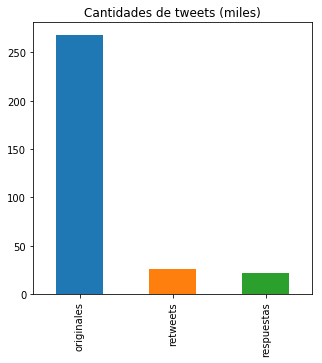

In [12]:
%%time
df_cutted = df_cut1(df)
print_dataset_proportions(df_cutted)

### 2 Promedio de conteos de retweets (usando retweet_count de la API de twitter)

In [13]:
def print_global_retweet_counts(data_f):
    avg_retweets_all = data_f.retweet_count.mean()
    print('Promedio de retweet counts (todo el dataset): \t\t{}'.format(avg_retweets_all))

    avg_retweets_nort = df_not_rt(data_f).retweet_count.mean()
    print('Promedio de retweet counts (solo tweets originales): \t{}'.format(avg_retweets_nort))

    # as retweets may point to the same tweet, we drop duplicates keeping the most updated one (oldest)
    avg_retweets_onlyrt =  df_only_rt(data_f).sort_values('created_at').drop_duplicates('retweeted_status__id_str', keep='last')\
        .retweet_count.mean()
    print('Promedio de retweet counts (solo retweets): \t\t{}'.format(avg_retweets_onlyrt))

### 2.0 Promedio de conteos de retweets (Global)

In [14]:
%%time
print_global_retweet_counts(df)

Promedio de retweet counts (todo el dataset): 		230.27960739243582
Promedio de retweet counts (solo tweets originales): 	20.10311669106444
Promedio de retweet counts (solo retweets): 		340.61649884960786
CPU times: user 396 ms, sys: 4 ms, total: 400 ms
Wall time: 476 ms


### 2.1 Promedio de conteos de retweets (Recorte 1)

In [15]:
%%time
df_cutted = df_cut1(df)
print_global_retweet_counts(df_cutted)

Promedio de retweet counts (todo el dataset): 		43.183539706519255
Promedio de retweet counts (solo tweets originales): 	20.10311669106444
Promedio de retweet counts (solo retweets): 		127.1447774501063
CPU times: user 571 ms, sys: 271 µs, total: 571 ms
Wall time: 589 ms


# Recorte 2: tomar sólo usuarios para los que se trajo el máximo de tweets por fetch_timeline

[Aquí](https://developer.twitter.com/en/docs/tweets/timelines/api-reference/get-statuses-user_timeline.html) se puede ver que 3,200 es el máximo de tweets que se puede traer. Se filtra entonces los usuarios para los cuales se extrajo esa cantidad de tweets.

Se usará 'Recorte 2' para referirse a esa filtrado de tweets

In [16]:
def df_cut2(data_f, max_tweets=3200):
    _df_tweets_per_user = data_f.user__id_str.groupby(data_f.user__id_str).count()
    data_f['tweets_on_dataset'] = _df_tweets_per_user[data_f.user__id_str.values].values
    return data_f[data_f.tweets_on_dataset >= max_tweets]


### 3 Ventanas de tiempo recogidas

In [17]:
def print_time_windows(data_f):
    print('Tweet más temprano en el tiempo: \t{}'.format(data_f.created_at.min()))
    print('Tweet más tardío en el tiempo: \t\t{}'.format(data_f.created_at.max()))

    max_of_mins = data_f.created_at.groupby(data_f.user__id_str).min().max()
    print('Menor fecha de tweet disponible para todos los usuarios: {}'.format(max_of_mins))

### 3.0 Ventanas de tiempo recogidas (Global)

In [18]:
%%time
print_time_windows(df)

Tweet más temprano en el tiempo: 	2018-10-28 00:00:00
Tweet más tardío en el tiempo: 		2018-11-04 23:59:56
Menor fecha de tweet disponible para todos los usuarios: 2018-11-04 23:45:16
CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 82.1 ms


### 3.1 Ventanas de tiempo recogidas (Recorte 1)

In [19]:
%%time
df_cutted = df_cut1(df)
print_time_windows(df_cutted)

Tweet más temprano en el tiempo: 	2018-10-28 00:00:00
Tweet más tardío en el tiempo: 		2018-11-04 23:59:55
Menor fecha de tweet disponible para todos los usuarios: 2018-11-04 23:10:38
CPU times: user 476 ms, sys: 15.9 ms, total: 492 ms
Wall time: 527 ms


### 3.2 Ventanas de tiempo recogidas (Recorte 2)

In [20]:
%%time
df_cutted = df_cut2(df)
print_time_windows(df_cutted)

Tweet más temprano en el tiempo: 	2018-10-28 00:01:22
Tweet más tardío en el tiempo: 		2018-11-04 23:57:40
Menor fecha de tweet disponible para todos los usuarios: 2018-10-28 00:10:08
CPU times: user 232 ms, sys: 8 ms, total: 240 ms
Wall time: 291 ms


In [21]:
############### ??????????????
### 7578 usuarios que metieron mas de 3200 tweets en una semana?????
users_on_tweet_limit = df_cutted.id_str.count()
print('Usuarios que tienen (igual) o más que el límite de tweets: {}'.format(users_on_tweet_limit))

Usuarios que tienen (igual) o más que el límite de tweets: 7578


### 4 Histograma de tweets y retweets por fecha

In [22]:
def plot_tweets_and_retweets_by_date(data_f):
    fig, ax = plt.subplots(figsize=(10,5))
    (data_f.created_at.groupby(data_f["created_at"].dt.date).count()/1000).plot(kind="line", ax=ax, rot=90, legend=True, label='Todos los tweets')
    (data_f.created_at.groupby(df_only_rt(data_f)["created_at"].dt.date).count()/1000).plot(kind="line", ax=ax, rot=90, legend=True, label='Solo RT')
    (data_f.created_at.groupby(df_commented(data_f)["created_at"].dt.date).count()/1000).plot(kind="line", ax=ax, rot=90, legend=True, label='Solo con commentarios')
    ax.set_title('Histograma de tweets por fecha')
    ax.set_ylabel('cantidad (miles)')
    ax.set_xlabel('fecha')

### 4.0 Histograma de tweets y retweets por fecha (Global)

CPU times: user 838 ms, sys: 16 ms, total: 854 ms
Wall time: 920 ms


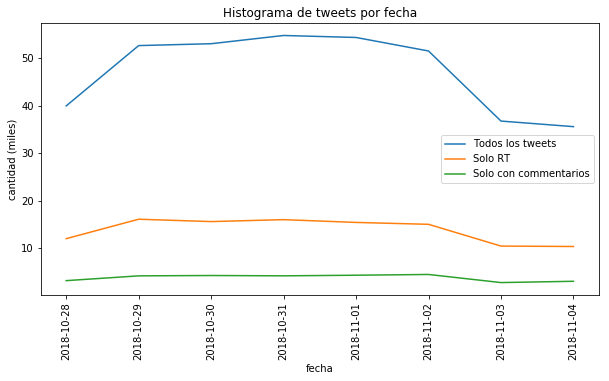

In [23]:
%%time
plot_tweets_and_retweets_by_date(df)

### 4.1 Histograma de tweets y retweets por fecha (Recorte 1)

CPU times: user 1.07 s, sys: 19.9 ms, total: 1.09 s
Wall time: 1.12 s


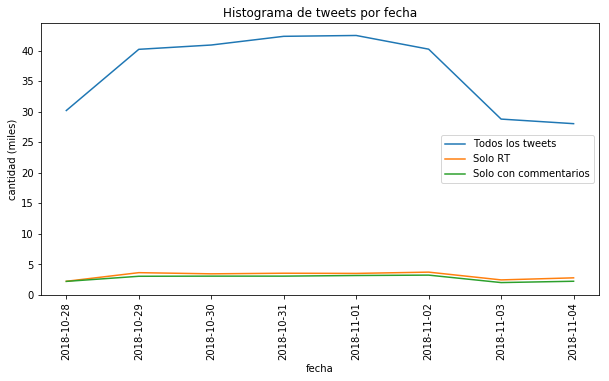

In [24]:
%%time
df_cutted = df_cut1(df)
plot_tweets_and_retweets_by_date(df_cutted)

### 4.2 Histograma de tweets y retweets por fecha (Recorte 2)

CPU times: user 665 ms, sys: 8.03 ms, total: 673 ms
Wall time: 673 ms


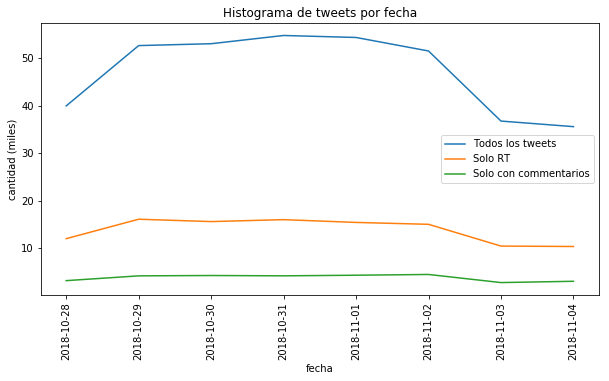

In [25]:
%%time
df_cutted = df_cut2(df)
plot_tweets_and_retweets_by_date(df)

### 5 Histograma de tweets y retweets por hora

Nota: se dejan afuera las primeras n horas por exceder los ordenes de magnitud para el ploteo

In [26]:
def plot_retweets_per_hour(data_f):
    data_f = data_f.copy()
    data_f['time_diff'] = df_only_rt(data_f).created_at - df_only_rt(data_f).retweeted_status__created_at
    # agregar columna de primer aparicion en el dataset (created at oo si es RT, primer RT en el grupo)
    counts_per_hour = df_only_rt(data_f).time_diff.groupby((df_only_rt(data_f).time_diff / np.timedelta64(1, 'D')).round(0)).count()
    
    def _find_first_n_outliers():
        head = counts_per_hour[0]
        for i in range(1, len(counts_per_hour)):
            if head < 2 * counts_per_hour[i]:
                break
            head = counts_per_hour[i]
        return i
    n_head_outliers = _find_first_n_outliers()
    first_n_hours_considered = 56

    print(counts_per_hour.head(n_head_outliers))
    print('Hay {} valores a plotear'.format(counts_per_hour.count()))
    counts_per_hour.head(first_n_hours_considered)[n_head_outliers:].plot(kind="line")

### 5.0 Histograma de tweets y retweets por hora

time_diff
0.0    89496
1.0    15610
2.0     2305
3.0      655
Name: time_diff, dtype: int64
Hay 497 valores a plotear
CPU times: user 348 ms, sys: 8.11 ms, total: 356 ms
Wall time: 364 ms


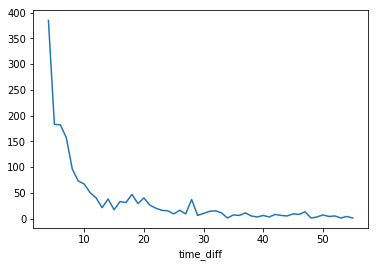

In [27]:
%%time
counts = plot_retweets_per_hour(df)### Histograma de tweets y retweets por hora

### 5.1 Histograma de tweets y retweets por hora (Recorte 1)

time_diff
0.0    21379
1.0     3645
2.0      308
3.0       67
Name: time_diff, dtype: int64
Hay 8 valores a plotear
CPU times: user 516 ms, sys: 104 ms, total: 620 ms
Wall time: 501 ms


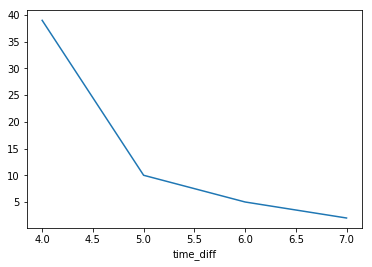

In [28]:
%%time
df_cutted = df_cut1(df)
counts = plot_retweets_per_hour(df_cutted)

### 5.2 Histograma de tweets y retweets por hora (Recorte 2)

time_diff
0.0    47
1.0    21
Name: time_diff, dtype: int64
Hay 3 valores a plotear
CPU times: user 277 ms, sys: 79.9 ms, total: 356 ms
Wall time: 240 ms


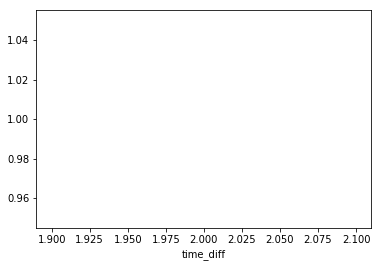

In [29]:
%%time
df_cutted = df_cut2(df)
counts = plot_retweets_per_hour(df_cutted)

### Retweets por hora de los primeros n tweets

In [30]:
# TODO

# n = 5
# top_retweeted = df.nlargest(5, 'retweet_count')
# top_retweeted

Primer intento: ¿los tweets con más retweet counts aparecen en los storylines de otros users considerados?

In [31]:
# for t_id in top_retweeted.id_str:
#     retweeted = df[df.retweeted_status__id_str == str(t_id)]
#     print(retweeted.shape[0])

Segundo intento: considerar los top retweet_counts que sí ...

In [32]:
# for t_id in top_retweeted.id_str:
#     retweeted = df[df.retweeted_status__id_str == str(t_id)]
#     retweeted['time_diff'] = retweeted.created_at - retweeted.retweeted_status__created_at
#     retweeted.time_diff.groupby((retweeted.time_diff / np.timedelta64(1, 'h')).round(0)).count().plot(kind="bar")

In [33]:
# retweeted = df[df.retweeted_status__id_str == str(1056986168024330240)]
# retweeted.created_at.groupby(retweeted["created_at"].dt.hour).count().plot(kind="line")

In [34]:
# row_max_rt = df.retweet_count.idxmax()
# print(df.iloc[row_max_rt, :])
# print(row_max_rt)
# print(type(row_max_rt))